# Understanding feature interactions with SHAP : sklearn's RandomForestRegressor with OHE inputs

In [1]:
import pandas
import sklearn
import scipy
from sklearn import model_selection, linear_model, preprocessing, metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy import cluster
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rxns_df_x = pandas.read_csv("godineau2023_reactions_OHE.csv")
rxns_x = rxns_df_x.to_numpy().copy()
rxns_x = np.delete(rxns_x, 0, 1)
rxns_df_x = rxns_df_x.drop("Unnamed: 0", axis=1)
rxns_df_y = pandas.read_csv("godineau2023_yields_OHE.csv")
rxns_y = rxns_df_y.to_numpy().copy()
rxns_y = np.delete(rxns_y, 0, axis=1)
rxns_df_y = rxns_df_y[["Yield of 3aa"]]

In [3]:
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_df_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [4]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

C:\Users\Public.utilisateur\AppData\Local\Temp\ipykernel_15284\1165176309.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestRegressor(random_state=42)

In [5]:
#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.658265719865249
Validation RMSE:11.951637218117858
Validation MAE:8.587779999999999
Test Set Accuracy with r2 : 0.6763216865290409
Test RMSE:12.25361065779185
Test MAE:9.438047500000001


Slightly more accurate than the non-OHE version. The validation set is less accurate than the 80/20 model while the test set is more accurate.

In [6]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_val, check_additivity=False)

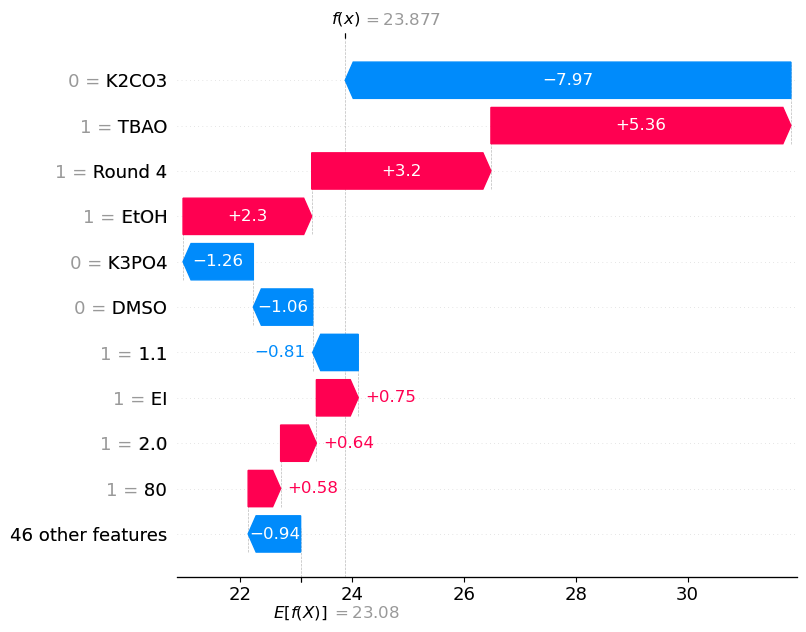

In [8]:
shap.plots.waterfall(shap_values[0], max_display=11)

Every observation here makes sense in respect to the results.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


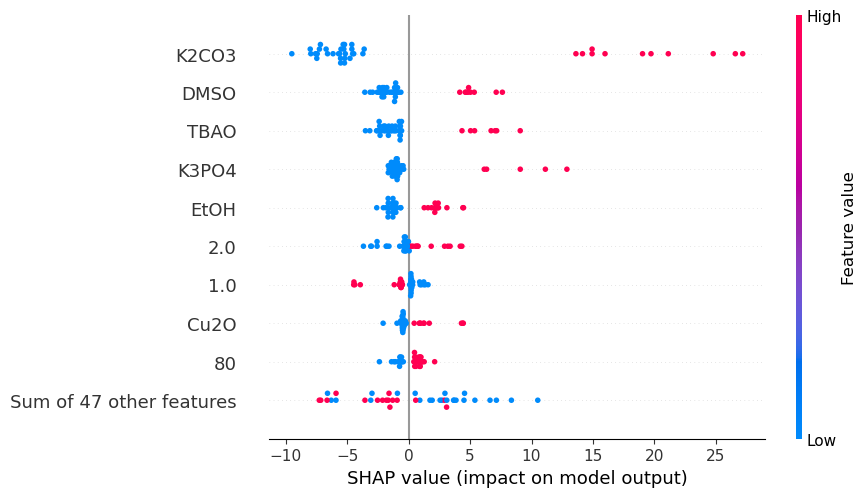

In [9]:
shap.plots.beeswarm(shap_values)

All the top features except the 1.0 base equivalent are those that make the yield higher when they are present (value = 1). Their positive effect is confirmed in data_exploration.ipynb

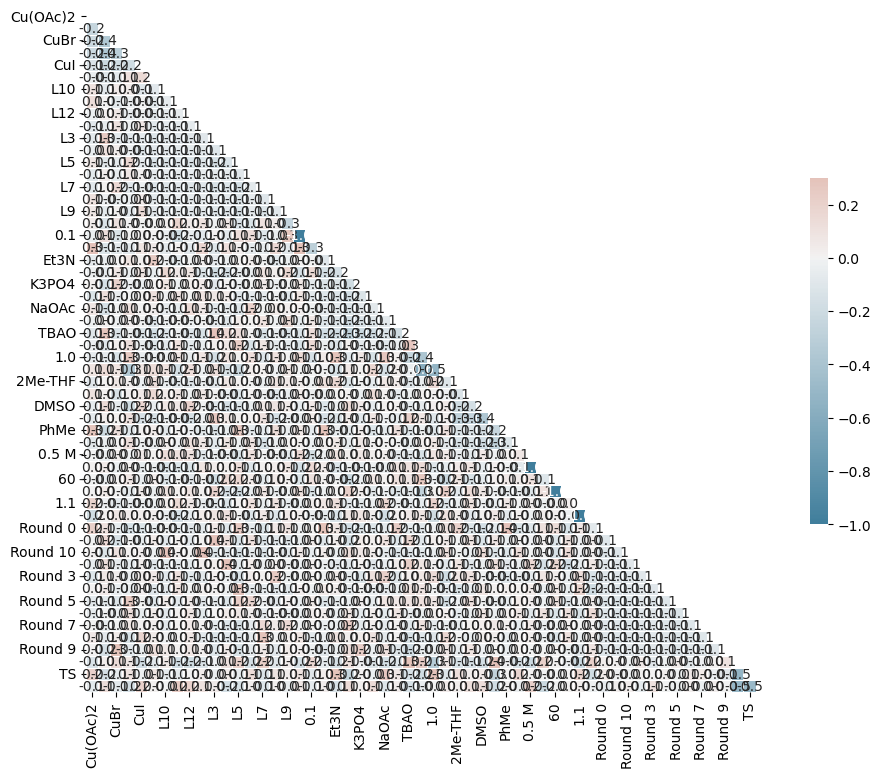

In [9]:
# Compute the correlation matrix
corr = x_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5},
annot=True, fmt=".1f")
plt.show()

That is a lot of interactions. Somewhat expected from a chemical system, though we should use another visualisation method for them to be clearer.

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


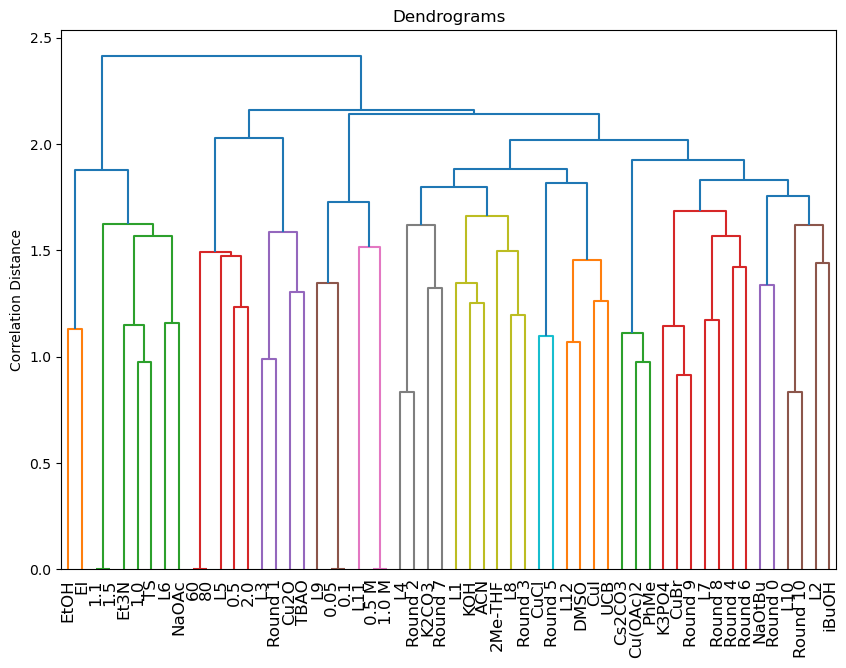

In [10]:
correlation_matrix = x_train.corr()
correlation_matrix = np.corrcoef(correlation_matrix)
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix
import scipy.cluster.hierarchy as sch
clustering = sch.linkage(dist_matrix, method="complete")
#clustering = shap.utils.hclust(X_train, metric='correlation')
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = hierarchy.dendrogram(clustering, labels=x_train.columns)
# Rotate labels for better readability
plt.xticks(rotation=90)
# Increase label size for better visibility
plt.tick_params(axis='x', which='major', labelsize=12)
plt.ylabel('Correlation Distance')
plt.show()

Nice feature interactions:
- the temperatures (60 and 80) are in the same cluster
- BnNH2 equivalents 1.1, 1.5 are in the same cluster
- Rounds 8, 4, and 6 are in the same cluster
- Molarities 0.5 and 1 are in the same cluster
- Ligand equivalents 0.1 and 0.05 are in the same cluster
##### Other than that:
- Rounds, Acquisition types, Solvents, Bases, Ligands, Cu sources are scattered throughout. Some are closer to each other (example: rounds 9, 8, 6 and 4 in the same cluster).

The use of OHE has made the recognition of interactions easier, especially when it comes to temperature (if 60 -> 0, then 80 -> 1 and vice versa), which is why this model is more efficient than its non-OHE counterpart.

In [11]:
masker = shap.maskers.Partition(x_train, clustering=clustering)
explainer2 = shap.PartitionExplainer(model.predict, masker)
shap_values2 = explainer2(x_val)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:   8%|▊         | 3/40 [00:16<01:52,  3.04s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X d

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  15%|█▌        | 6/40 [00:29<02:17,  4.05s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X d

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  25%|██▌       | 10/40 [00:46<02:15,  4.51s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  35%|███▌      | 14/40 [01:03<02:00,  4.62s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  45%|████▌     | 18/40 [01:20<01:43,  4.70s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  52%|█████▎    | 21/40 [01:33<01:28,  4.63s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  68%|██████▊   | 27/40 [01:53<00:49,  3.84s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  75%|███████▌  | 30/40 [02:07<00:44,  4.50s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  92%|█████████▎| 37/40 [02:36<00:13,  4.36s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer: 41it [02:53,  4.34s/it]                        


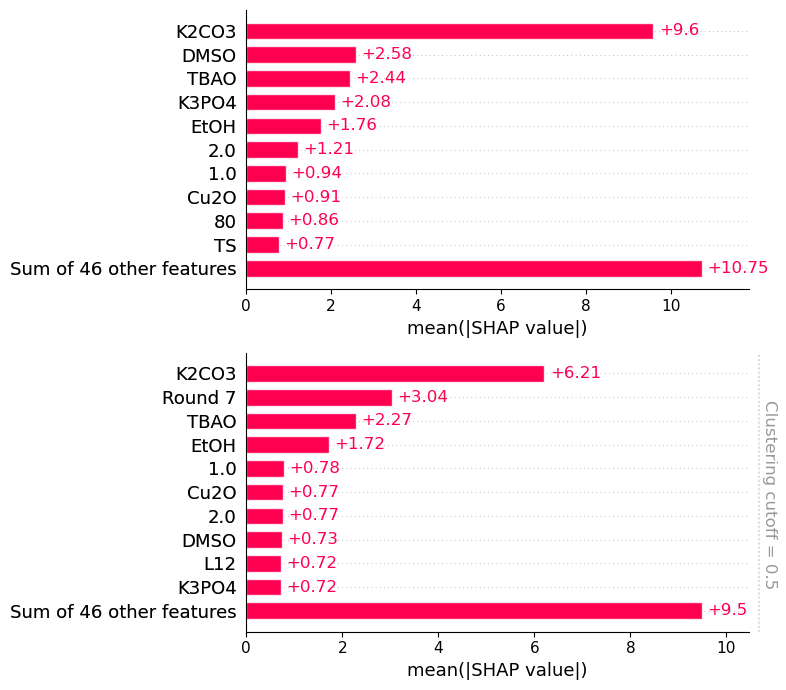

In [15]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_values, max_display=11, show=False)
ax1 = fig.add_subplot(212)
shap.plots.bar(
shap_values2, max_display=11, show=False, clustering_cutoff=0.5
)
plt.tight_layout()
plt.show()

The correlations are very significant here.

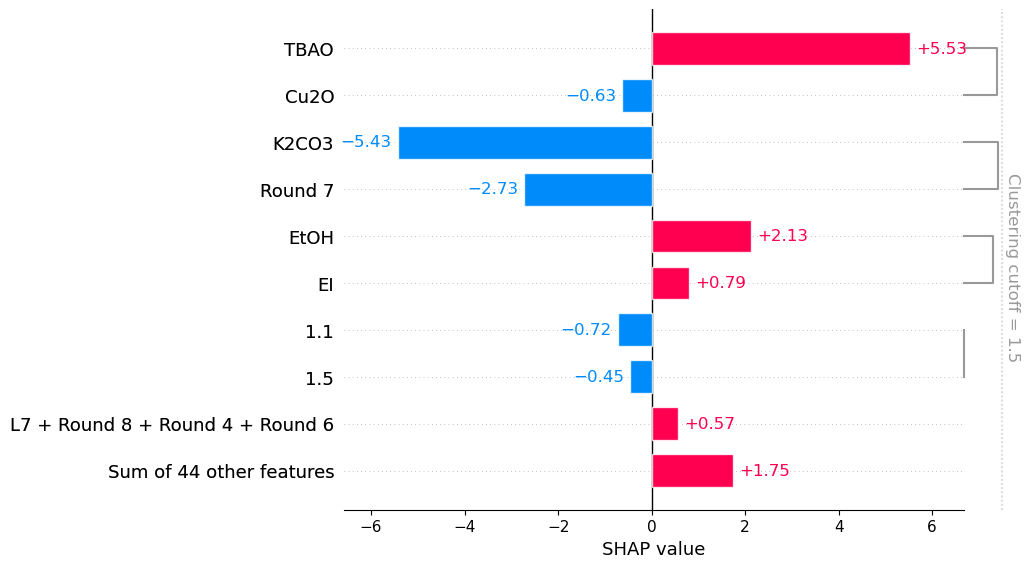

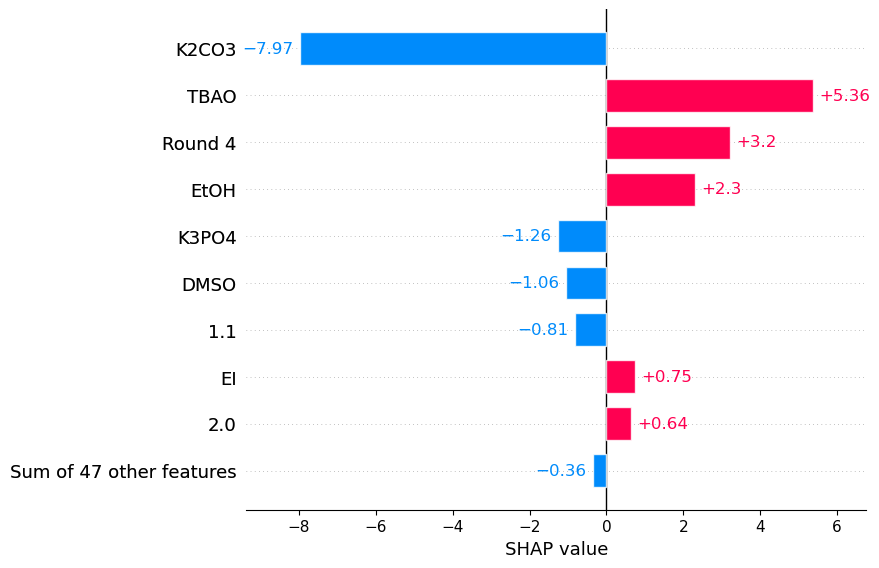

In [14]:
shap.plots.bar(shap_values2[0], clustering_cutoff=1.5)
shap.plots.bar(shap_values[0])

Some of the rounds getting clustered together is pretty nice.

## Combining OHE columns

In [23]:
def combine_one_hot(shap_values, name, mask, return_original=True):
    """  shap_values: an Explanation object
          name: name of new feature
          mask: bool array same lenght as features

         This function assumes that shap_values[:, mask] make up a one-hot-encoded feature
    """
    mask = np.array(mask)
    mask_col_names = np.array(shap_values.feature_names, dtype='object')[mask]

    sv_name = shap.Explanation(shap_values.values[:, mask],
                               feature_names=list(mask_col_names),
                               data=shap_values.data[:, mask],
                               base_values=shap_values.base_values,
                               display_data=shap_values.display_data,
                               instance_names=shap_values.instance_names,
                               output_names=shap_values.output_names,
                               output_indexes=shap_values.output_indexes,
                               lower_bounds=shap_values.lower_bounds,
                               upper_bounds=shap_values.upper_bounds,
                               main_effects=shap_values.main_effects,
                               hierarchical_values=shap_values.hierarchical_values,
                               clustering=shap_values.clustering,
                               )

    new_data = (sv_name.data * np.arange(sum(mask))).sum(axis=1).astype(int)

    svdata = np.concatenate([
        shap_values.data[:, ~mask],
        new_data.reshape(-1, 1)
    ], axis=1)

    if shap_values.display_data is None:
        svdd = shap_values.data[:, ~mask]
    else:
        svdd = shap_values.display_data[:, ~mask]

    svdisplay_data = np.concatenate([
        svdd,
        mask_col_names[new_data].reshape(-1, 1)
    ], axis=1)

    new_values = sv_name.values.sum(axis=1)
    svvalues = np.concatenate([
        shap_values.values[:, ~mask],
        new_values.reshape(-1, 1)
    ], axis=1)
    svfeature_names = list(np.array(shap_values.feature_names)[~mask]) + [name]

    sv = shap.Explanation(svvalues,
                          base_values=shap_values.base_values,
                          data=svdata,
                          display_data=svdisplay_data,
                          instance_names=shap_values.instance_names,
                          feature_names=svfeature_names,
                          output_names=shap_values.output_names,
                          output_indexes=shap_values.output_indexes,
                          lower_bounds=shap_values.lower_bounds,
                          upper_bounds=shap_values.upper_bounds,
                          main_effects=shap_values.main_effects,
                          hierarchical_values=shap_values.hierarchical_values,
                          clustering=shap_values.clustering,
                          )
    if return_original:
        return sv, sv_name
    else:
        return sv

In [24]:
rxns_df = pandas.read_csv("godineau2023_reactions_with_yields.tsv",sep='\t' )
def bool_feature(name):
    bool_list=[]
    for n in rxns_df_x.columns:
        if str(n) in list(set(rxns_df_x.columns.to_list()).intersection(set(rxns_df[f'{name}'].to_list()))):
            bool_list.append(True)
        else:
            bool_list.append(False)
    return np.array(bool_list)

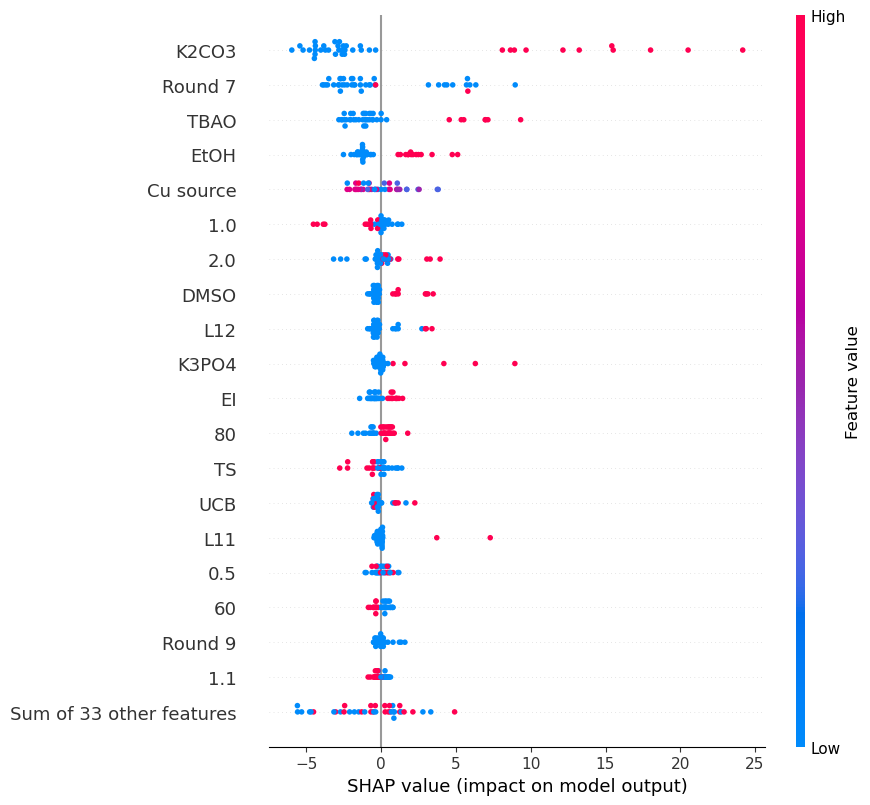

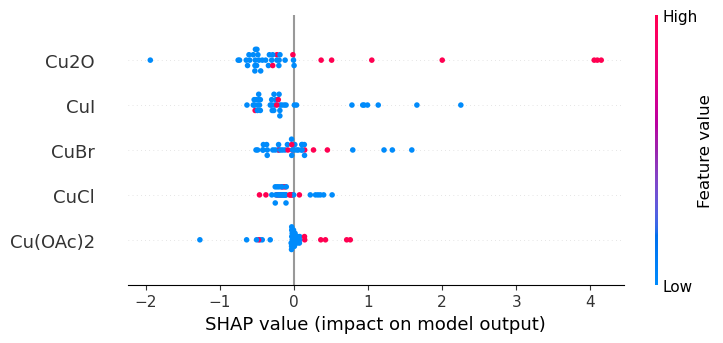

In [47]:
shap_values3,sv_occ = combine_one_hot(shap_values2, "Cu source", bool_feature('Cu source'))
shap.plots.beeswarm(shap_values3, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

Surprising to see CuBr (the Cu source leading to the highest yield) not only having a weak SHAP value but also having a positive SHAP value on the model output when it is not present. Consider that this might come from it not being used as many times as Cu2O which is the Cu source found the most times in the data set, and because it leads to lower yields than CuI when it is not present.

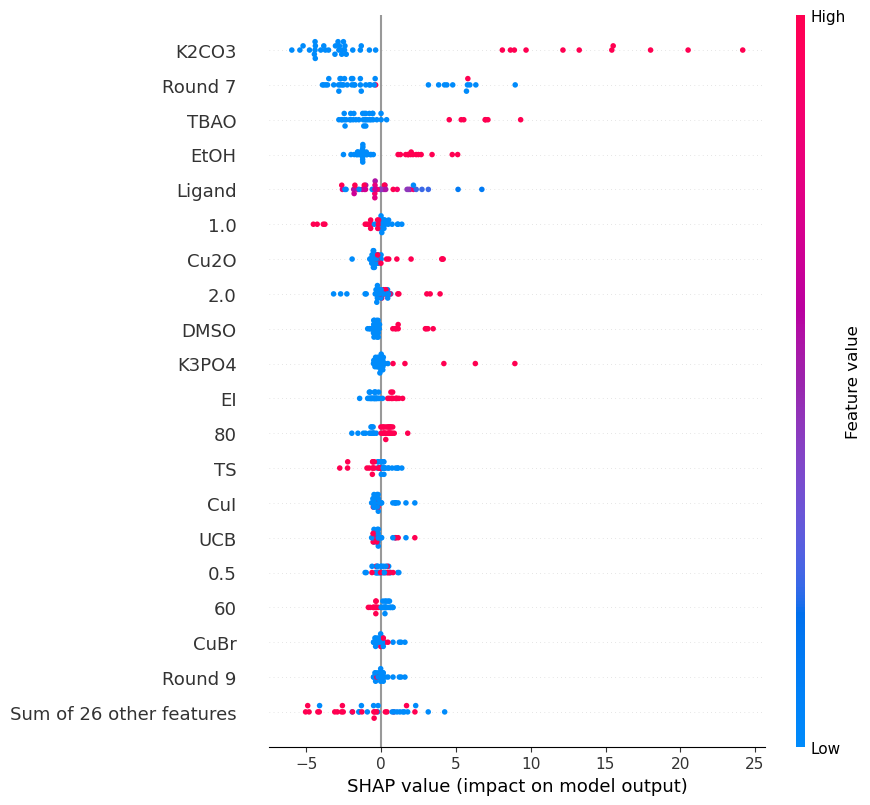

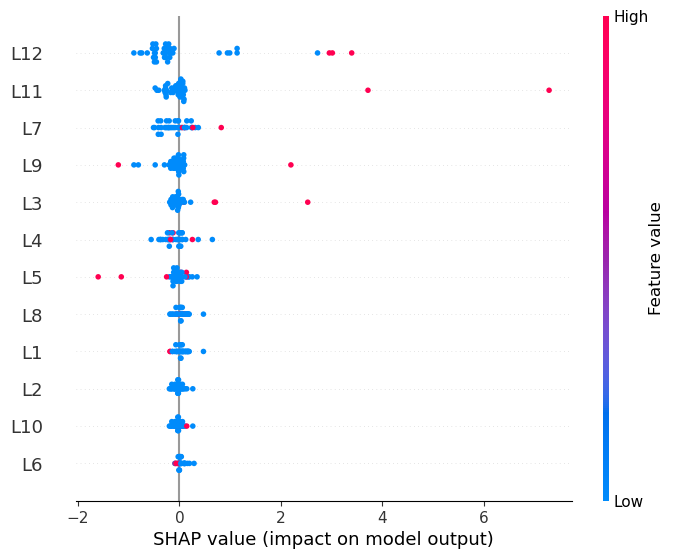

In [48]:
shap_values,sv_occ = combine_one_hot(shap_values2, "Ligand", bool_feature('Ligand'))
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

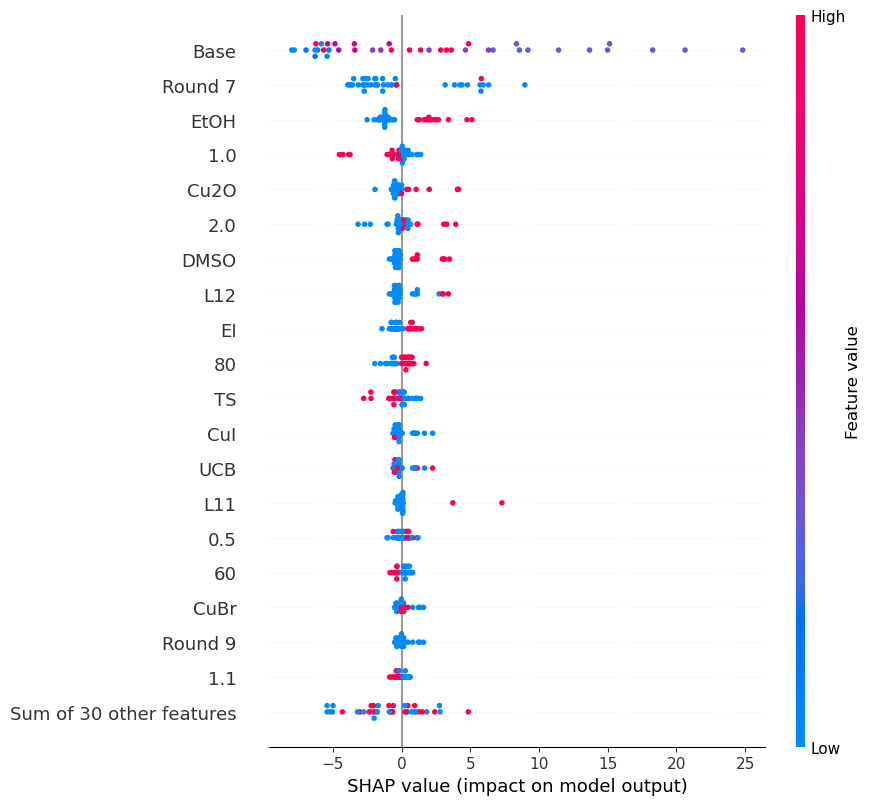

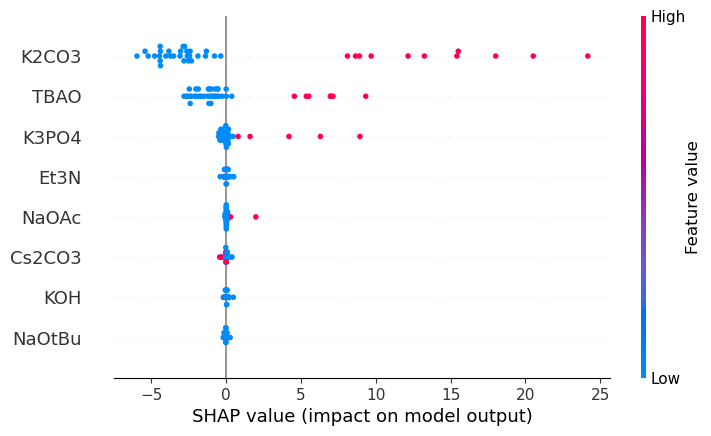

In [49]:
shap_values,sv_occ = combine_one_hot(shap_values2, "Base", bool_feature('Base'))
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

No surprises here, since K2CO3 is used more times than K3PO4, it having more SHAP values with bigger impacts makes sense despite K3PO4 leading to the highest yield overall. The only bases that seem to have a significantly negative impact the yield are Et3N and KOH, which is confirmed in data_exploration.ipynb

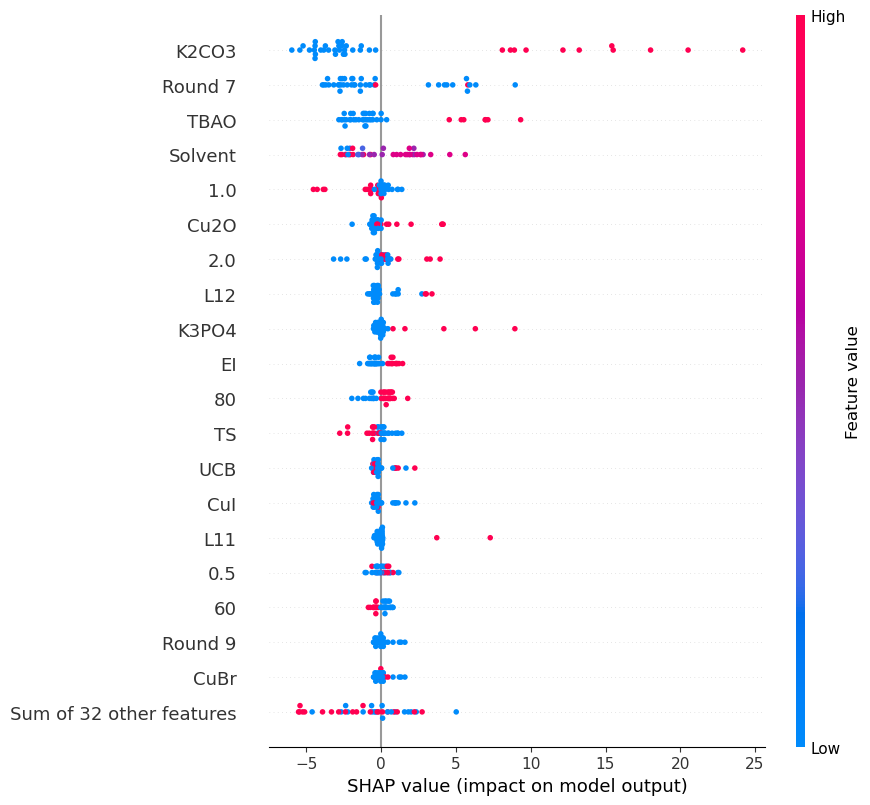

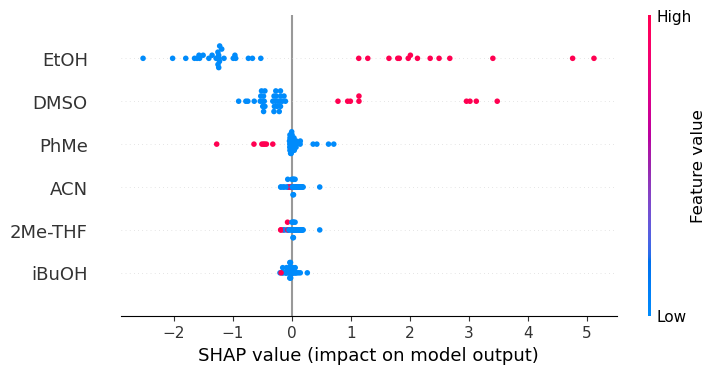

In [50]:
shap_values,sv_occ = combine_one_hot(shap_values2, "Solvent", bool_feature('Solvent'))
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

Same explanation here as to why EtOH has more SHAP values with higher impacts than DMSO despite DMSO being the solvent that lead to the highest yield. Notice PhMe is an especially inefficient solvent.

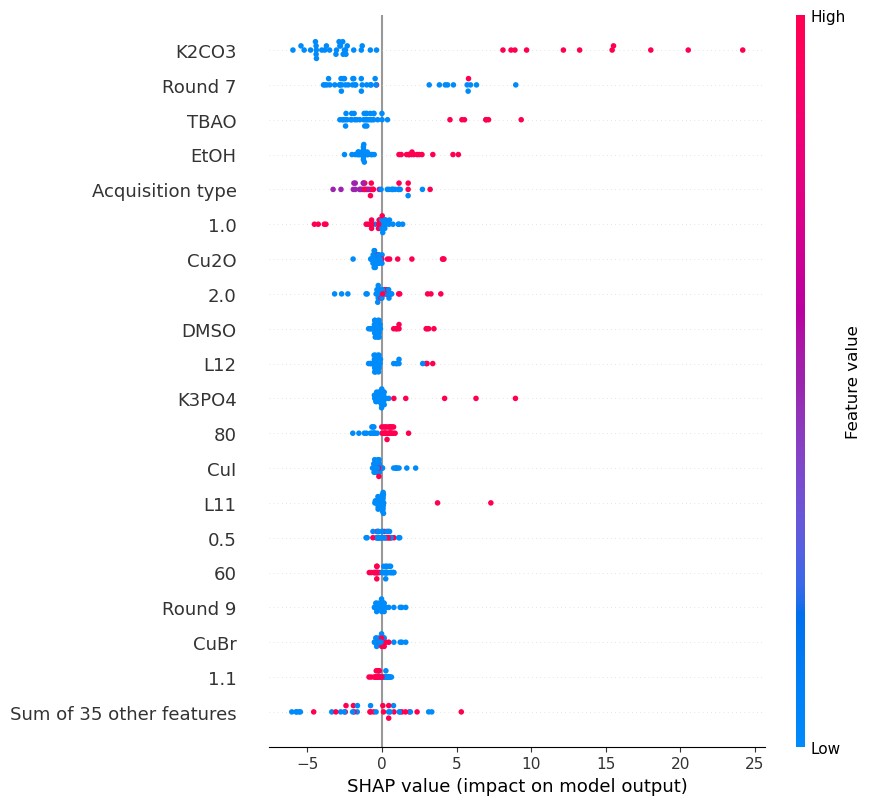

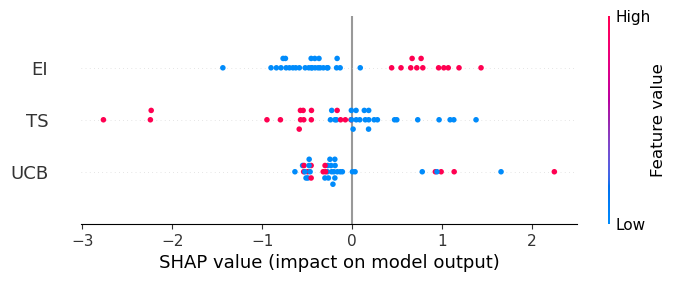

In [61]:
shap_values,sv_occ = combine_one_hot(shap_values2, "Acquisition type", bool_feature('Acquisition type'))
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

Expected improvement seems to overall be the best acquisition method for this experiment.

Text(0.5, 0, 'Actual')

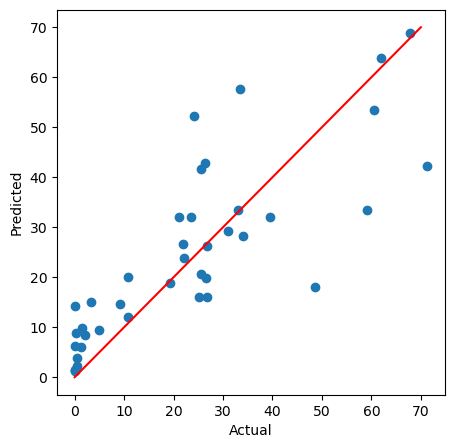

In [63]:
plt.figure(figsize=(5,5))
plt.scatter(y_val, y_val_pred)
plt.plot([0,70], [0,70], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

Text(0.5, 0, 'Actual')

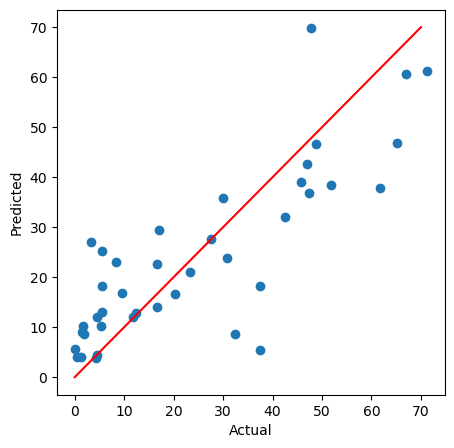

In [65]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred)
plt.plot([0,70], [0,70], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

The model is not the most accurate, but shows some relatively precise points.

# Another try without the acquisition method and round

In [7]:
rxns_df_x = rxns_df_x.drop("EI", axis = 1)
rxns_df_x = rxns_df_x.drop("TS", axis = 1)
rxns_df_x = rxns_df_x.drop("UCB", axis = 1)
for i in range(0,11):
    rxns_df_x = rxns_df_x.drop(f"Round {i}", axis=1)
rxns_df_x

,Cu(OAc)2,Cu2O,CuBr,CuCl,CuI,L1,L10,L11,L12,L2,...,DMSO,EtOH,PhMe,iBuOH,0.5 M,1.0 M,60,80,1.1,1.5
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,1,0
2,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
260,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1
261,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,1,1,0,0,1
262,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0


In [8]:
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_df_y, test_size=0.1, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)
# going for the 90/5/5 model that we found was the most accurate

In [9]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

C:\Users\Public.utilisateur\AppData\Local\Temp\ipykernel_7108\1165176309.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestRegressor(random_state=42)

In [10]:
#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.7317925098201055
Validation RMSE:10.740095522852675
Validation MAE:8.330969230769231
Test Set Accuracy with r2 : 0.7084584848512654
Test RMSE:10.020776572808265
Test MAE:7.811535714285719


This model is definitely more accurate than the one we looked at previously. By taking out noise and picking a different method of splitting our dataset, we have largely improved our model.

In [11]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [12]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_val, check_additivity=False)

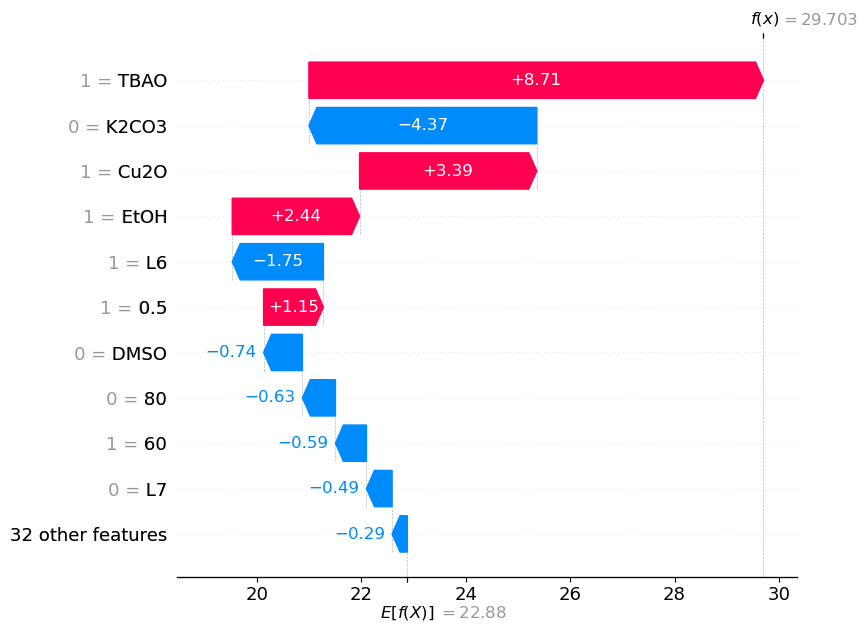

In [13]:
shap.plots.waterfall(shap_values[0], max_display=11)

We can see that the the absolute SHAP value of TBAO has augmented while K2CO3's has diminished. Cu2O and EtOH have also seemed to gain in importance, which fits with our observation of the data.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


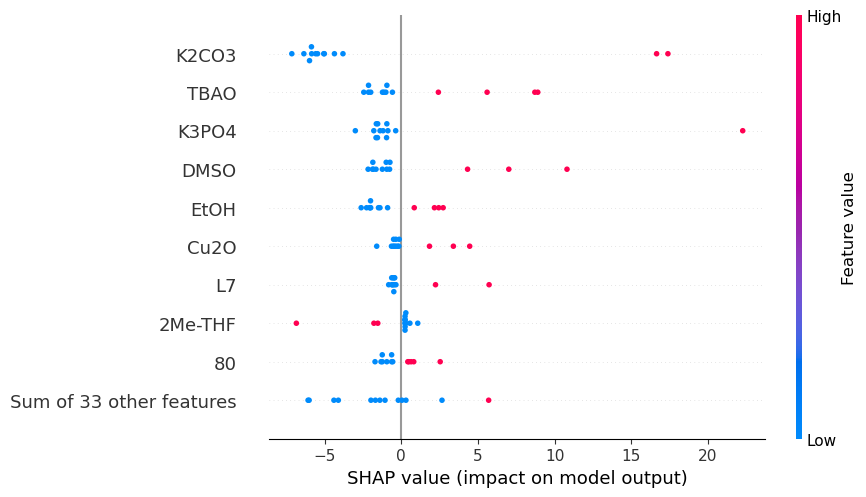

In [14]:
shap.plots.beeswarm(shap_values)

This is a satisfactory plot which fits both qualitatively and quantitatively with the graphs of data_exploration.ipynb. Getting rid of the noise created by the round and acquisition type has helped give more importance to the actual chemical compounds at play in this reaction.

In [15]:
shap_values1 = explainer(x_test, check_additivity=False)

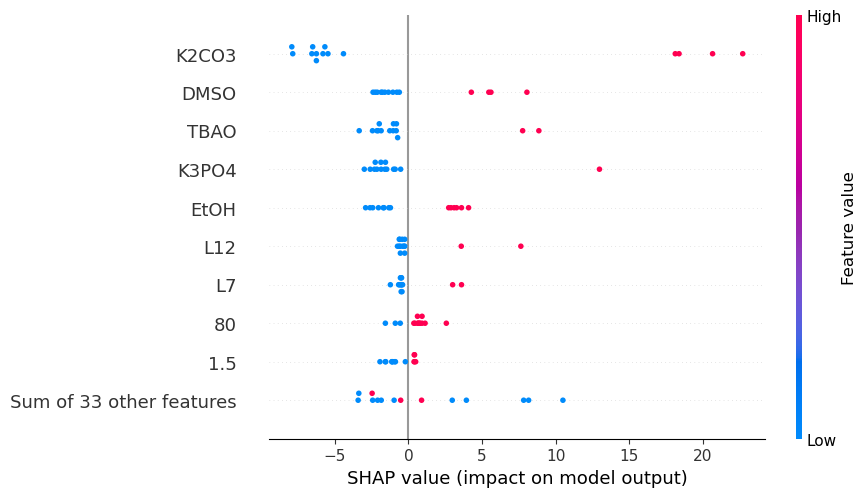

In [17]:
shap.plots.beeswarm(shap_values1)

The notable difference between this plot and the one based on the validation set is the absence of Cu2O in the list of features with the highest SHAP values. However there is the presence of a new feature pertaining to a parameter we had not before: the 1.5 BnNH2 equivalent which is the most appropriate for this reaction. Overall this plot also fits very nicely with the observations of data_exploration.ipynb.

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


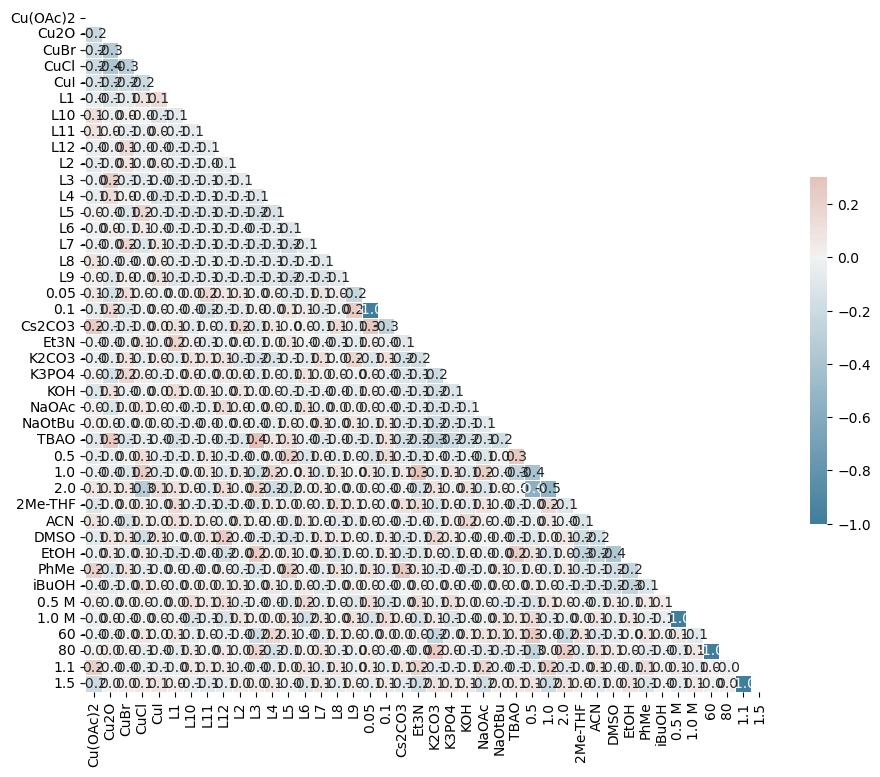

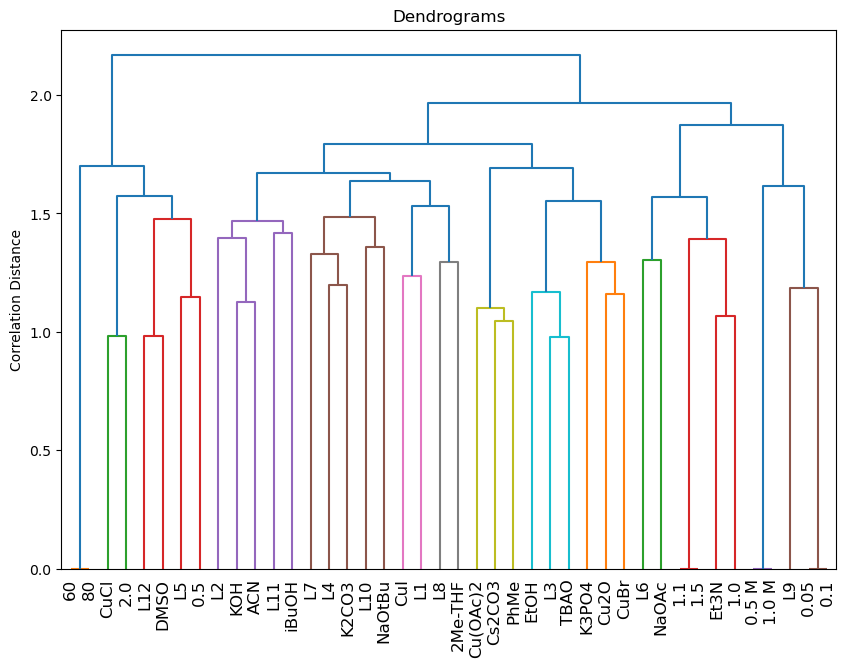

In [18]:
# Compute the correlation matrix
corr = x_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5},
annot=True, fmt=".1f")
correlation_matrix = x_train.corr()
correlation_matrix = np.corrcoef(correlation_matrix)
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix
import scipy.cluster.hierarchy as sch
clustering = sch.linkage(dist_matrix, method="complete")
#clustering = shap.utils.hclust(X_train, metric='correlation')
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = hierarchy.dendrogram(clustering, labels=x_train.columns)
# Rotate labels for better readability
plt.xticks(rotation=90)
# Increase label size for better visibility
plt.tick_params(axis='x', which='major', labelsize=12)
plt.ylabel('Correlation Distance')
plt.show()

If two features are clustered together it means that the model has recognized that they are either never/often not equal to the same value (1-0) or that the opposite (1-1, 0-0). The correlation distance is a measure of how "close" the features are, which is why for example the distance between the temperatures is 0 because they will alway be the opposite value of the other.

Things to note:
- All the features with only two values available (temperature, BnNH2 equivalent, molarity, ligand equivalent) are clustered together
- K3PO4 (the best base) is clustered with Cu2O and CuBr which are the two most efficient Cu sources.
- Some ligands are clustered together at varying proximities

In [19]:
masker = shap.maskers.Partition(x_train, clustering=clustering)
explainer2 = shap.PartitionExplainer(model.predict, masker)
shap_values2 = explainer2(x_val)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  31%|███       | 4/13 [00:19<00:30,  3.37s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X d

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  54%|█████▍    | 7/13 [00:31<00:25,  4.24s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X d

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  85%|████████▍ | 11/13 [00:44<00:07,  3.78s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  92%|█████████▏| 12/13 [00:50<00:04,  4.35s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

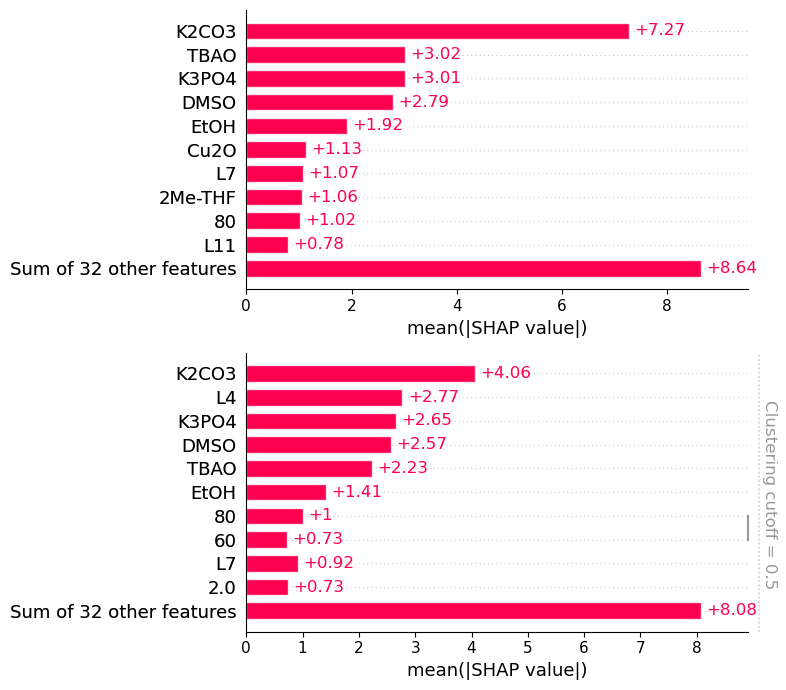

In [20]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_values, max_display=11, show=False)
ax1 = fig.add_subplot(212)
shap.plots.bar(
shap_values2, max_display=11, show=False, clustering_cutoff=0.5
)
plt.tight_layout()
plt.show()

With clustering, there is a significant difference in the SHAP values. With a 0.5 cutout, we only cluster the features with two possible values yet the effect it has on the values is very big !

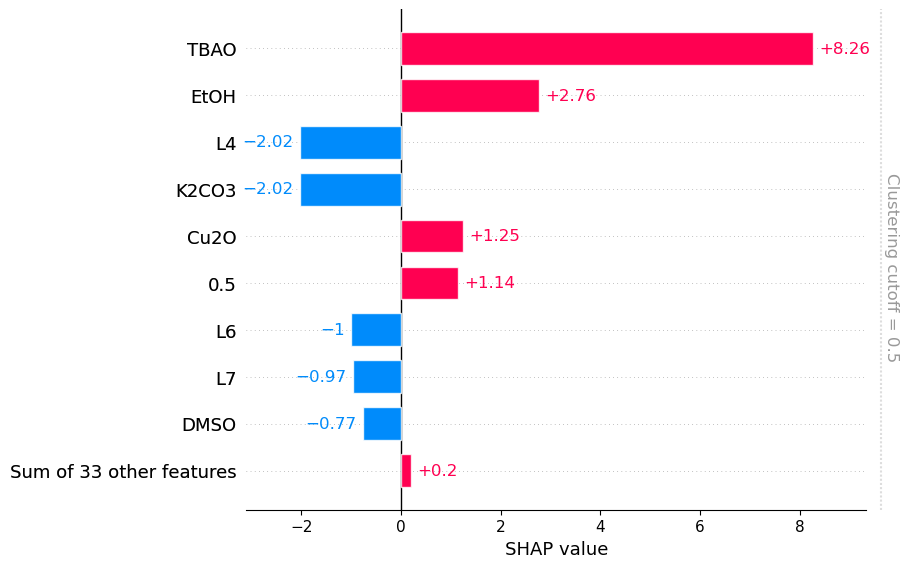

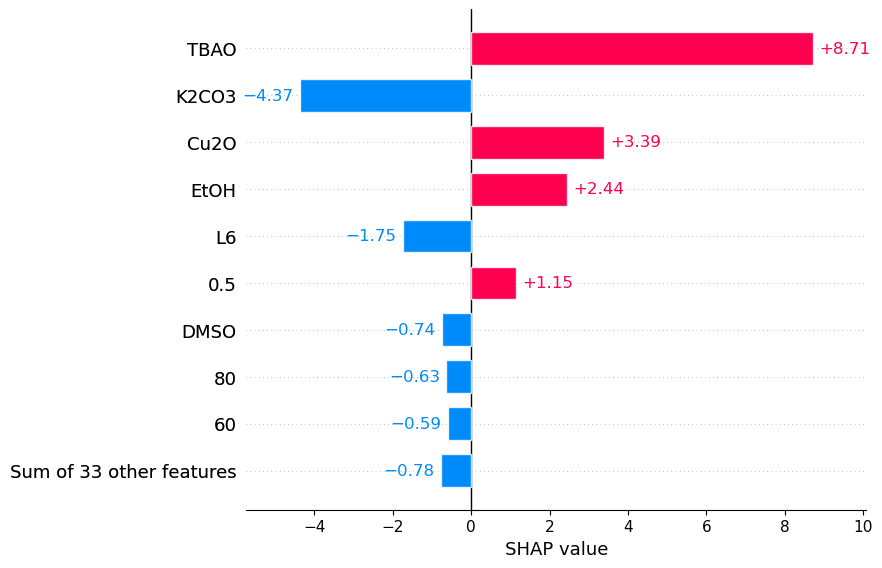

In [21]:
shap.plots.bar(shap_values2[0], clustering_cutoff=0.5)
shap.plots.bar(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


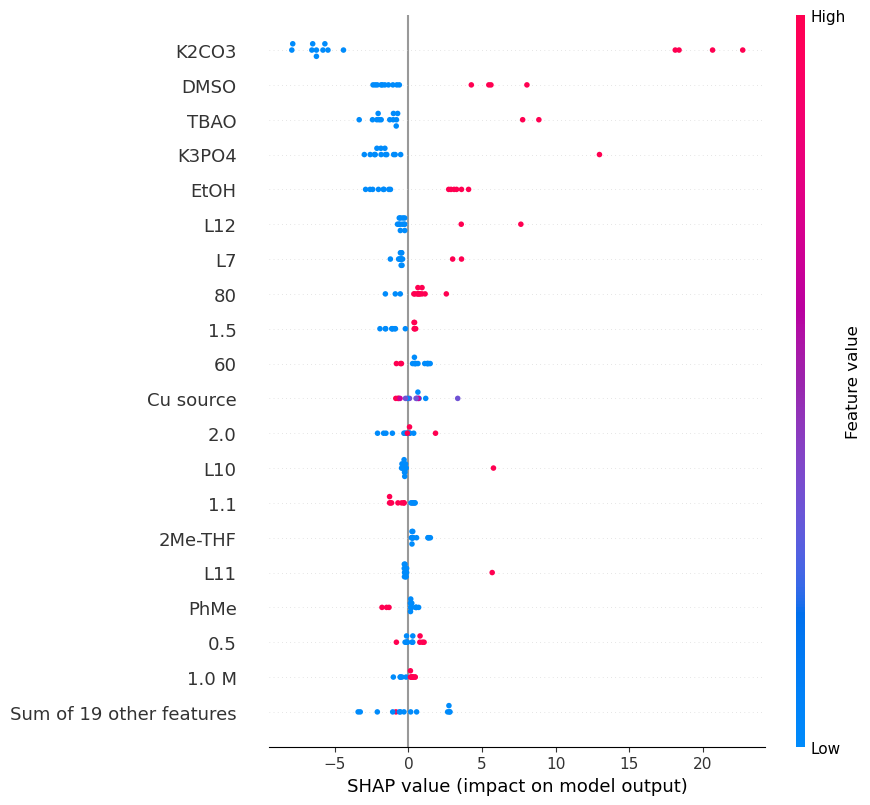

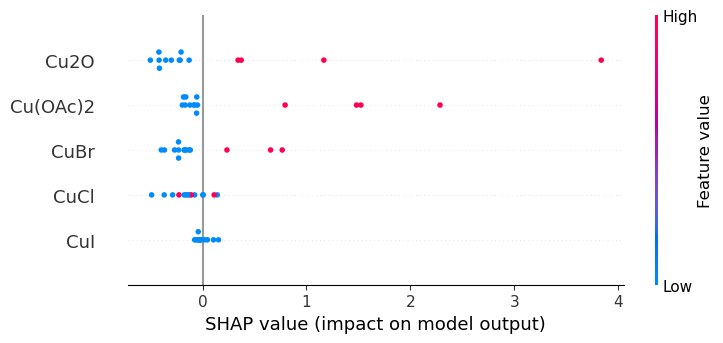

In [26]:
shap_values3,sv_occ = combine_one_hot(shap_values1, "Cu source", bool_feature('Cu source'))
shap.plots.beeswarm(shap_values3, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

This plot is from the values of the test set, without being clustered. These results are in accordance with what we have previously seen, there is not much to add.

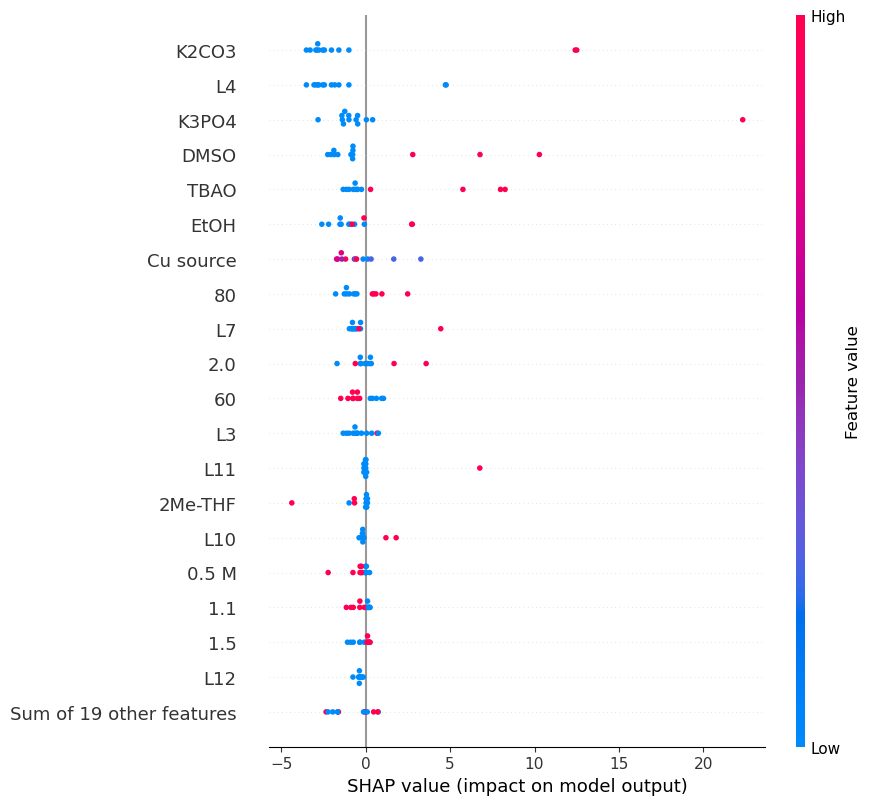

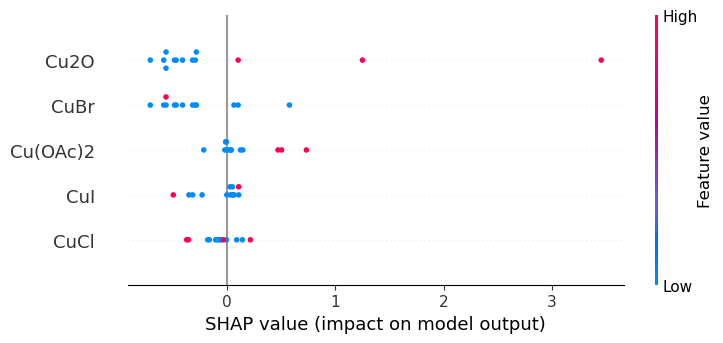

In [27]:
shap_values3,sv_occ = combine_one_hot(shap_values2, "Cu source", bool_feature('Cu source'))
shap.plots.beeswarm(shap_values3, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

With clustering, the results are different: most notably low values (0) of CuBr seem to lead to both significantly positive and negative SHAP values. This is an example of SHAP values being counter-intuitive, and why we should be critical when using them in explanations. A guess as to why we are observing this could come from the fact that CuBr is in a cluste with Cu2O; the latter being used for a higher number of experiments than the former, leading to seeing low yields when CuBr is not present as it is among the best Cu sources but also higher yields since the clustering will put emphasis on the cases where Cu2O (also one of the best Cu sources) is present.

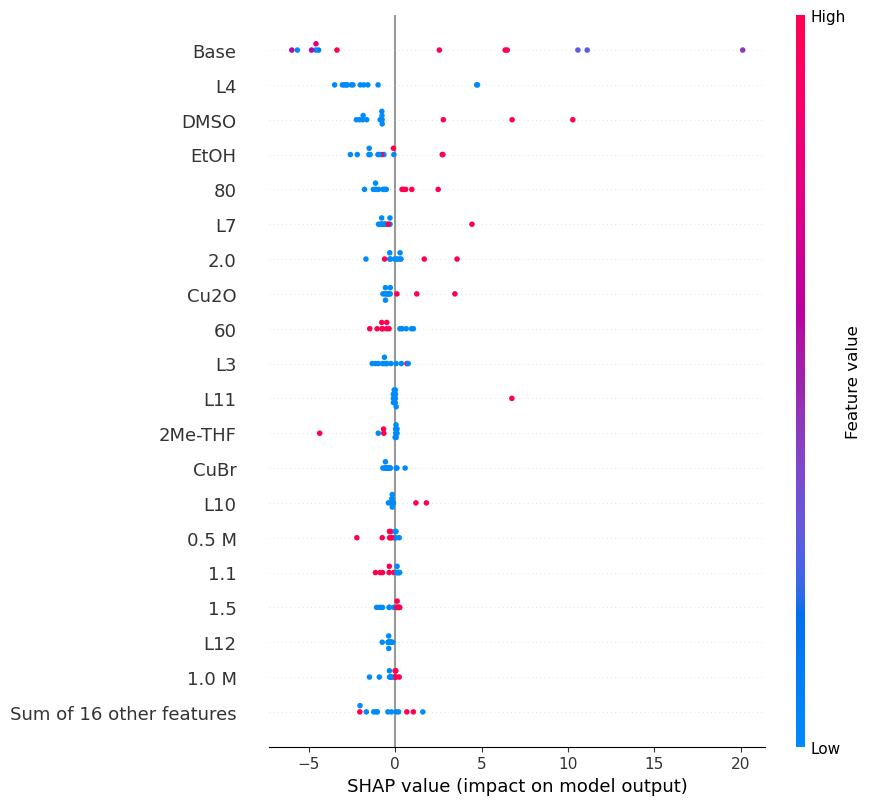

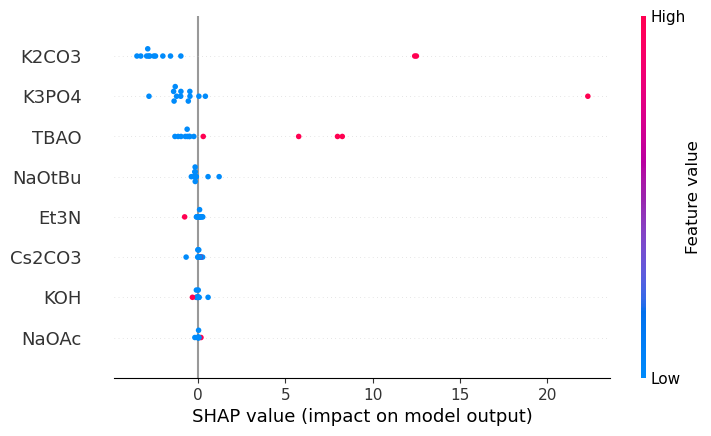

In [28]:
shap_values3,sv_occ = combine_one_hot(shap_values2, "Base", bool_feature('Base'))
shap.plots.beeswarm(shap_values3, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

Even with clustering, the results here are similar to what we would expect.

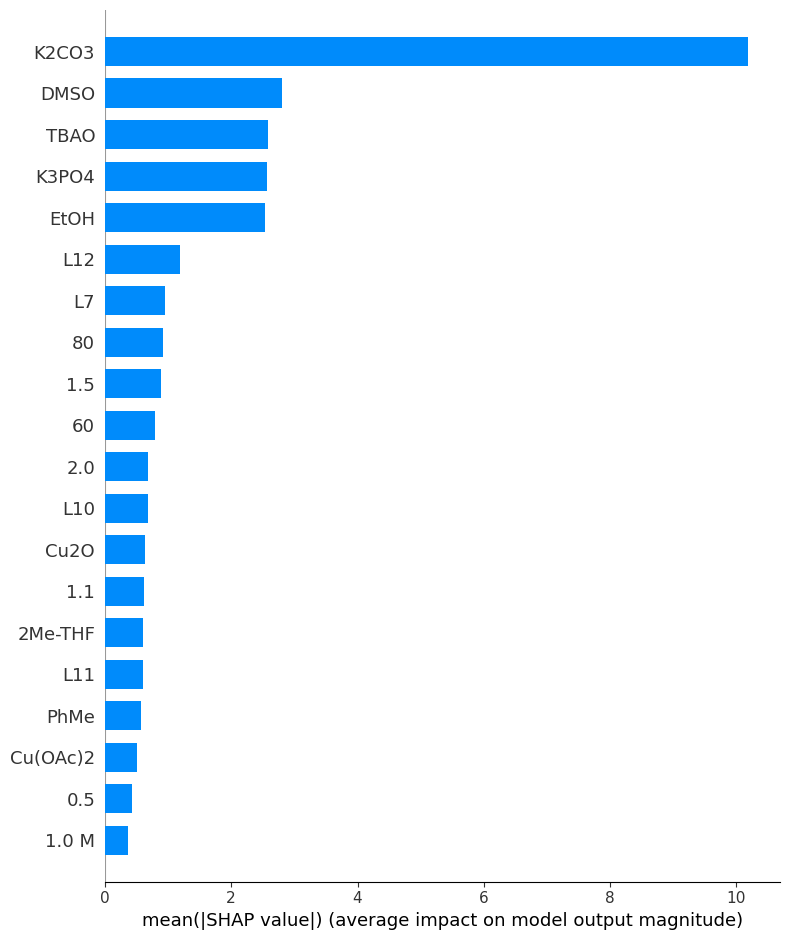

In [33]:
#Summary Plot as a bar chart
shap.summary_plot(shap_values = shap_values1, features = x_test, max_display=20, plot_type='bar')


K2CO3 clearly has the biggest mean impact on the yield predicted by the model. According to data_exploration.ipynb it is used the most out of all the available bases and it consistently leads to higher yields than all the other bases except for K3PO4 (which also has one of the highest mean SHAP values). 

Note that these are all **absolute** mean SHAP values which  means that some of the top features can lead to lower yields ! Most notably the solvents PhMe and 2Me-THF and the 1.1 BnNH2 equivalent which usually lead to the lowest yields of the dataset have high absolute mean SHAP values because they have big negative impacts on model outputs.

# Out of curiosity

In [34]:
# let's remove all the columns that have a 1 correlation with another column
rxns_df_x = rxns_df_x.drop("60", axis=1)
rxns_df_x = rxns_df_x.drop('1.1', axis = 1)
rxns_df_x = rxns_df_x.drop("0.05", axis=1)
rxns_df_x = rxns_df_x.drop("0.5 M", axis=1)

In [41]:
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_df_y, test_size=0.1, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [42]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(random_state=42)

In [43]:
#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.73765151211261
Validation RMSE:10.622138887103814
Validation MAE:7.897153846153843
Test Set Accuracy with r2 : 0.6677935141762044
Test RMSE:10.696833338656829
Test MAE:8.442064285714295


This model is not more accurate, despite losing columns that could have been considered as superfluous.